In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import re

## Data Processing

In [2]:
full = pd.read_csv("Data/full_data.csv")
full.head()

Player Pos  Age   Tm   G    MP   PER    TS%   3PAr    FTr  \
0  Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005  0.250   
1            Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009  0.421   
2         Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431  0.363   
3           Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088  0.202   
4           Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053  0.105   

   ...  All_NBA_Pos  All_NBA_Team  All_NBA_Pts_Won  All_NBA_Pts_Max  \
0  ...          NaN           NaN              NaN              NaN   
1  ...          NaN           NaN              NaN              NaN   
2  ...          NaN           NaN              NaN              NaN   
3  ...          NaN           NaN              NaN              NaN   
4  ...          NaN           NaN              NaN              NaN   

   All_NBA_Share  All_NBA_1st_Team_Votes  All_NBA_2nd_Team_Votes  \
0            NaN                     NaN                     NaN   
1            NaN                     NaN                     NaN   
2            NaN                     NaN                     NaN   
3            NaN                     NaN                     NaN   
4            NaN                     NaN                     NaN   

   All_NBA_3rd_Team_Votes       year  All_NBA_Boolean  
0                     NaN  1988-1989            False  
1                     NaN  1988-1989            False  
2                     NaN  1988-1989            False  
3                     NaN  1988-1989            False  
4                     NaN  1988-1989            False  

[5 rows x 37 columns]

We will need to remove the following columns because they are directly linked to the response variable.
- All_NBA_Pos: Position when considered for All NBA team. NA= no votes.
- All_NBA_Team: Which all-nba team the player was selected to (if any). ORV = player received votes for All-NBA team but did not make it. NA= no votes.
- All_NBA_Pts_Won: # of All-NBA points received. NA= no votes.
- All_NBA_Pts_Max: max number of All-NBA points possible for that year. Varies by year.NA= no votes.
- All_NBA_Share: share of All-NBA points won. All_NBA_Pts_Won/All_NBA_Pts_Max. This could be our response variable.
- All_NBA_1st_Team_Votes: # of 1st team votes
- All_NBA_2nd_Team_Votes: # of 2nd team votes
- All_NBA_3rd_Team_Votes: # of 3rd team votes

In [3]:
## Remove All ALL Stats except boolean All_Stars
remove_all_star = full.loc[:, ~full.columns.str.startswith('All_')]
remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]
remove_all_star.head()

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_36302/1871535054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]


Player Pos  Age   Tm   G    MP   PER    TS%   3PAr    FTr  \
0  Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005  0.250   
1            Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009  0.421   
2         Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431  0.363   
3           Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088  0.202   
4           Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053  0.105   

   ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  player_id       year  \
0  ...  2.0  2.9  0.082  -1.9  -0.2 -2.1   0.0  abdulka01  1988-1989   
1  ...  0.5  0.9  0.066  -3.0  -0.4 -3.4  -0.2  acresma01  1988-1989   
2  ...  2.9  8.3  0.143   2.7   0.2  2.9   3.4  adamsmi01  1988-1989   
3  ...  1.0  2.2  0.093  -1.1  -0.8 -2.0   0.0  alarima01  1988-1989   
4  ...  0.0  0.0 -0.035  -5.5  -1.7 -7.2  -0.1  allenra01  1988-1989   

   All_NBA_Boolean  
0            False  
1            False  
2            False  
3            False  
4            False  

[5 rows x 29 columns]

In [4]:
clean_df = remove_all_star.dropna()
clean_df

Player Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0      Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005   
1                Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009   
2             Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431   
3               Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088   
4               Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053   
...                     ...  ..  ...  ...  ..   ...   ...    ...    ...   
15438        Tremont Waters  PG   24  TOT   3    50   5.4  0.357  0.643   
15439         Derrick White  SG   27  TOT  75  2199  14.8  0.549  0.461   
15440       Justise Winslow  SF   25  TOT  48   774  13.1  0.479  0.257   
15441          Moses Wright  PF   23  TOT   4    14  18.3  0.470  0.250   
15442        Thaddeus Young  PF   33  TOT  52   845  17.0  0.548  0.176   

         FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  player_id  \
0      0.250  ...  2.0  2.9  0.082  -1.9  -0.2 -2.1   0.0  abdulka01   
1      0.421  ...  0.5  0.9  0.066  -3.0  -0.4 -3.4  -0.2  acresma01   
2      0.363  ...  2.9  8.3  0.143   2.7   0.2  2.9   3.4  adamsmi01   
3      0.202  ...  1.0  2.2  0.093  -1.1  -0.8 -2.0   0.0  alarima01   
4      0.105  ...  0.0  0.0 -0.035  -5.5  -1.7 -7.2  -0.1  allenra01   
...      ...  ...  ...  ...    ...   ...   ...  ...   ...        ...   
15438  0.000  ...  0.1  0.0 -0.042  -7.8   0.1 -7.7  -0.1  watertr01   
15439  0.294  ...  2.3  5.1  0.111   0.4   0.6  0.9   1.6  whitede01   
15440  0.257  ...  1.1  0.8  0.048  -2.7   1.0 -1.7   0.1  winslju01   
15441  0.750  ...  0.0  0.1  0.180   1.1   0.4  1.4   0.0  wrighmo01   
15442  0.180  ...  1.3  2.2  0.126   0.1   2.1  2.2   0.9  youngth01   

            year  All_NBA_Boolean  
0      1988-1989            False  
1      1988-1989            False  
2      1988-1989            False  
3      1988-1989            False  
4      1988-1989            False  
...          ...              ...  
15438  2021-2022            False  
15439  2021-2022            False  
15440  2021-2022            False  
15441  2021-2022            False  
15442  2021-2022            False  

[15382 rows x 29 columns]

Data Distribution by season 

In [5]:
clean_df.groupby(['year'])['All_NBA_Boolean'].count()

year
1988-1989    352
1989-1990    380
1990-1991    386
1991-1992    381
1992-1993    390
1993-1994    402
1994-1995    406
1995-1996    427
1996-1997    440
1997-1998    437
1998-1999    437
1999-2000    438
2000-2001    439
2001-2002    439
2002-2003    427
2003-2004    440
2004-2005    463
2005-2006    455
2006-2007    458
2007-2008    451
2008-2009    445
2009-2010    440
2010-2011    449
2011-2012    478
2012-2013    467
2013-2014    480
2014-2015    490
2015-2016    475
2016-2017    485
2017-2018    537
2018-2019    526
2019-2020    527
2020-2021    539
2021-2022    596
Name: All_NBA_Boolean, dtype: int64

## Hierarchical Modeling

The data has multiple seasons included in the dataframe. From our general knowledge we would suspect that each season, different categories of performance matters to select All NBA stars. Therefore, we can say that the data is nested and we would need to use a hierarchical model. 

First we will try to run a full hierarchical model with all the predictors that are numeric.

In [6]:
season_idxs, seasons = pd.factorize(clean_df.year)
coords = {
    "season": seasons,
    "obs_id": np.arange(len(season_idxs)),
}
coords

{'season': Index(['1988-1989', '1989-1990', '1990-1991', '1991-1992', '1992-1993',
        '1993-1994', '1994-1995', '1995-1996', '1996-1997', '1997-1998',
        '1998-1999', '1999-2000', '2000-2001', '2001-2002', '2002-2003',
        '2003-2004', '2004-2005', '2005-2006', '2006-2007', '2007-2008',
        '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013',
        '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
        '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
       dtype='object'),
 'obs_id': array([    0,     1,     2, ..., 15379, 15380, 15381])}

We will also need to subset the numeric columns.

In [7]:
numeric_col = pd.DataFrame(clean_df.dtypes[:-1]).reset_index()
numeric_col = numeric_col[numeric_col[0] != 'object']
numeric_col.columns = ['name', 'type']
numeric_col = list(numeric_col.name)
numeric_col

['Age',
 'G',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP']

In [8]:
with pm.Model(coords=coords) as hierarchical_model:
    season_idx = pm.Data("season_idx", season_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10000)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)

    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="season")

    nba_est = a[season_idx]
    for i,col in enumerate(numeric_col):
        # Set mu for new predictor
        mu = pm.Normal("mu_b{}".format(i), mu=0.0, sigma=10000)
        # Set Sigma for new predictor
        sigma = pm.HalfNormal("sigma_b{}".format(i), 5.0)
        # Set beta for new predictor
        var = pm.Normal("b{}".format(i), mu=mu, sigma=sigma, dims="season")
        # Continous update of nba_est formula
        nba_est = nba_est + var[season_idx] * clean_df[col].values
    
    # Data likelihood
    nba_like = pm.Bernoulli(
        "nba_like",
        logit_p = nba_est,
        observed = clean_df.All_NBA_Boolean.astype(int).values
    )


In [9]:
with hierarchical_model:
    hierarchical_trace_full = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b22, sigma_b22, mu_b22, b21, sigma_b21, mu_b21, b20, sigma_b20, mu_b20, b19, sigma_b19, mu_b19, b18, sigma_b18, mu_b18, b17, sigma_b17, mu_b17, b16, sigma_b16, mu_b16, b15, sigma_b15, mu_b15, b14, sigma_b14, mu_b14, b13, sigma_b13, mu_b13, b12, sigma_b12, mu_b12, b11, sigma_b11, mu_b11, b10, sigma_b10, mu_b10, b9, sigma_b9, mu_b9, b8, sigma_b8, mu_b8, b7, sigma_b7, mu_b7, b6, sigma_b6, mu_b6, b5, sigma_b5, mu_b5, b4, sigma_b4, mu_b4, b3, sigma_b3, mu_b3, b2, sigma_b2, mu_b2, b1, sigma_b1, mu_b1, b0, sigma_b0, mu_b0, a, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26685 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective s

#### Problems with Hierarchical Models

Even with increased tune and target acceptance the sampler did not converge. Looking at the metrics will not showcase the data well because the rhat statistic is too large.

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_36302/3584041679.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  trarr = pm.plots.traceplot(hierarchical_trace_full)


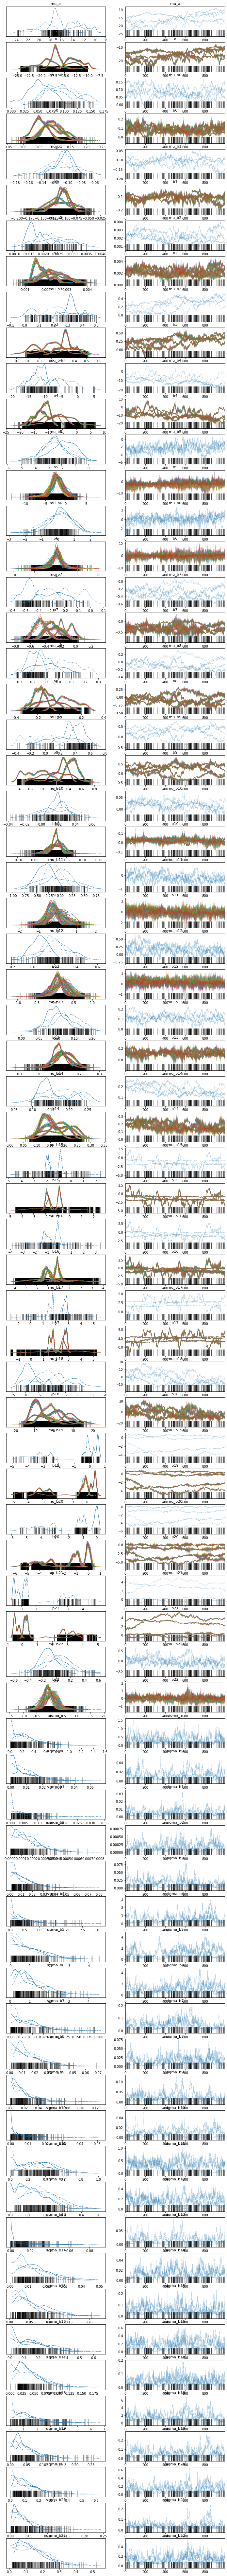

In [36]:
# plt.rcParams["plot.max_subplots"] = 100
az.rcParams["plot.max_subplots"] = 200# This finishes without error
trarr = pm.plots.traceplot(hierarchical_trace_full)
fig = plt.gcf() # to get the current figure...
fig.savefig("hierarchical_trace.png") # and save it directly

In [39]:
sum_hierarchical_full = pm.summary(hierarchical_trace_full)
sum_hierarchical_full

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a         -16.115  3.265 -22.982  -10.725      1.394    1.044       6.0   
a[1988-1989] -16.115  3.285 -21.919   -9.665      1.398    1.046       6.0   
a[1989-1990] -16.119  3.285 -21.995   -9.719      1.398    1.046       6.0   
a[1990-1991] -16.082  3.277 -21.988   -9.673      1.391    1.041       6.0   
a[1991-1992] -16.111  3.283 -22.119   -9.890      1.394    1.043       6.0   
...              ...    ...     ...      ...        ...      ...       ...   
sigma_b18      1.330  1.027   0.031    3.223      0.164    0.125      50.0   
sigma_b19      0.050  0.041   0.001    0.124      0.007    0.005      43.0   
sigma_b20      0.121  0.092   0.004    0.293      0.011    0.008      57.0   
sigma_b21      0.036  0.027   0.001    0.081      0.003    0.002      45.0   
sigma_b22      0.138  0.086   0.011    0.291      0.009    0.006      83.0   

              ess_tail  r_hat  
mu_a              12.0   1.89  
a[1988-1989]      14.0   1.88  
a[1989-1990]      13.0   1.87  
a[1990-1991]      14.0   1.87  
a[1991-1992]      13.0   1.87  
...                ...    ...  
sigma_b18         74.0   1.09  
sigma_b19         91.0   1.09  
sigma_b20         81.0   1.06  
sigma_b21        131.0   1.09  
sigma_b22        152.0   1.06  

[864 rows x 9 columns]

In [42]:
sum_hierarchical_full.sort_values('r_hat', ascending=False).head(20)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b19[2014-2015] -1.563  1.827  -4.376    0.722      0.882    0.671       5.0   
b19[1994-1995] -1.554  1.828  -4.385    0.705      0.882    0.672       5.0   
b19[1998-1999] -1.552  1.824  -4.397    0.703      0.880    0.670       5.0   
mu_b21          1.663  1.821  -0.642    4.471      0.879    0.670       5.0   
b19[2005-2006] -1.571  1.827  -4.393    0.699      0.882    0.672       5.0   
b19[2020-2021] -1.567  1.825  -4.399    0.703      0.881    0.671       5.0   
b19[2019-2020] -1.571  1.827  -4.360    0.726      0.882    0.671       5.0   
b19[2018-2019] -1.570  1.826  -4.390    0.698      0.881    0.671       5.0   
b19[2017-2018] -1.589  1.827  -4.393    0.705      0.882    0.672       5.0   
b21[2017-2018]  1.649  1.824  -0.683    4.423      0.881    0.671       5.0   
mu_b19         -1.564  1.826  -4.381    0.702      0.881    0.671       5.0   
b19[2012-2013] -1.572  1.828  -4.393    0.699      0.882    0.672       5.0   
b21[2003-2004]  1.671  1.820  -0.671    4.454      0.878    0.669       5.0   
b21[2002-2003]  1.662  1.822  -0.654    4.474      0.879    0.670       5.0   
b21[2005-2006]  1.659  1.822  -0.654    4.457      0.879    0.670       5.0   
b21[2001-2002]  1.660  1.821  -0.661    4.466      0.879    0.669       5.0   
b21[2000-2001]  1.662  1.822  -0.652    4.481      0.879    0.670       5.0   
b21[1990-1991]  1.654  1.824  -0.654    4.468      0.880    0.670       5.0   
b21[1999-2000]  1.668  1.821  -0.669    4.461      0.879    0.669       5.0   
b21[1998-1999]  1.674  1.821  -0.667    4.474      0.879    0.669       5.0   

                ess_tail  r_hat  
b19[2014-2015]      26.0   2.54  
b19[1994-1995]      26.0   2.54  
b19[1998-1999]      26.0   2.54  
mu_b21              26.0   2.54  
b19[2005-2006]      26.0   2.54  
b19[2020-2021]      26.0   2.54  
b19[2019-2020]      26.0   2.54  
b19[2018-2019]      26.0   2.54  
b19[2017-2018]      26.0   2.54  
b21[2017-2018]      25.0   2.54  
mu_b19              26.0   2.54  
b19[2012-2013]      26.0   2.54  
b21[2003-2004]      26.0   2.53  
b21[2002-2003]      26.0   2.53  
b21[2005-2006]      25.0   2.53  
b21[2001-2002]      25.0   2.53  
b21[2000-2001]      24.0   2.53  
b21[1990-1991]      26.0   2.53  
b21[1999-2000]      26.0   2.53  
b21[1998-1999]      26.0   2.53

In [43]:
sum_hierarchical_full.sort_values('r_hat', ascending=False).tail(20)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b6[1993-1994]  0.451  1.335  -2.198    2.932      0.090    0.064     159.0   
b6[1988-1989] -0.240  1.468  -3.097    2.461      0.123    0.087     142.0   
b6[2002-2003] -0.240  1.455  -3.007    2.447      0.092    0.065     261.0   
b6[1989-1990] -0.012  1.405  -2.743    2.764      0.066    0.070     319.0   
b6[1995-1996]  0.051  1.338  -2.736    2.532      0.107    0.076     149.0   
b6[2003-2004] -0.293  1.359  -3.114    2.073      0.111    0.078     143.0   
b6[2019-2020]  0.245  1.283  -2.355    2.624      0.075    0.053     251.0   
b6[1990-1991] -0.243  1.300  -3.008    1.814      0.093    0.066     206.0   
b6[2017-2018]  0.268  1.237  -2.112    2.547      0.059    0.049     438.0   
b6[2016-2017]  0.435  1.408  -2.124    3.273      0.072    0.054     343.0   
b6[2015-2016]  0.342  1.190  -1.933    2.592      0.075    0.053     217.0   
b6[1994-1995]  0.293  1.354  -2.168    3.017      0.077    0.055     274.0   
b6[2013-2014]  0.194  1.047  -1.738    2.123      0.056    0.040     373.0   
b6[1996-1997] -0.123  1.267  -2.621    2.230      0.081    0.058     213.0   
b6[2009-2010] -0.147  1.327  -2.715    2.332      0.100    0.071     210.0   
b6[1997-1998]  0.289  1.274  -2.068    2.796      0.063    0.044     378.0   
b6[1999-2000] -0.009  1.352  -2.672    2.563      0.072    0.051     333.0   
b6[2000-2001] -0.075  1.408  -3.047    2.281      0.106    0.075     151.0   
b6[2005-2006] -0.026  1.173  -2.353    2.040      0.074    0.052     251.0   
b6[2001-2002] -0.043  1.384  -2.671    2.538      0.074    0.053     312.0   

               ess_tail  r_hat  
b6[1993-1994]     553.0   1.03  
b6[1988-1989]     556.0   1.03  
b6[2002-2003]     480.0   1.03  
b6[1989-1990]     809.0   1.03  
b6[1995-1996]     695.0   1.03  
b6[2003-2004]     596.0   1.03  
b6[2019-2020]     866.0   1.02  
b6[1990-1991]     817.0   1.02  
b6[2017-2018]     852.0   1.02  
b6[2016-2017]     473.0   1.02  
b6[2015-2016]     924.0   1.02  
b6[1994-1995]     523.0   1.02  
b6[2013-2014]     881.0   1.02  
b6[1996-1997]     763.0   1.02  
b6[2009-2010]     739.0   1.02  
b6[1997-1998]     846.0   1.02  
b6[1999-2000]     418.0   1.02  
b6[2000-2001]     664.0   1.02  
b6[2005-2006]     859.0   1.02  
b6[2001-2002]     532.0   1.02

Since there were too many divergences, we will try to use different hierarchical steps. Starting in 2004, the NBA showed different playing tactics. We will try to restructure the nested structure of the data to be pre-2004 and post-2004.

In [11]:
unnested = clean_df.copy()
unnested['year'] = np.where(unnested['year'].str.split('-').str[0].astype(int) > 2003, 'Post', 'Pre')
unnested

Player Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0      Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005   
1                Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009   
2             Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431   
3               Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088   
4               Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053   
...                     ...  ..  ...  ...  ..   ...   ...    ...    ...   
15438        Tremont Waters  PG   24  TOT   3    50   5.4  0.357  0.643   
15439         Derrick White  SG   27  TOT  75  2199  14.8  0.549  0.461   
15440       Justise Winslow  SF   25  TOT  48   774  13.1  0.479  0.257   
15441          Moses Wright  PF   23  TOT   4    14  18.3  0.470  0.250   
15442        Thaddeus Young  PF   33  TOT  52   845  17.0  0.548  0.176   

         FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  player_id  year  \
0      0.250  ...  2.0  2.9  0.082  -1.9  -0.2 -2.1   0.0  abdulka01   Pre   
1      0.421  ...  0.5  0.9  0.066  -3.0  -0.4 -3.4  -0.2  acresma01   Pre   
2      0.363  ...  2.9  8.3  0.143   2.7   0.2  2.9   3.4  adamsmi01   Pre   
3      0.202  ...  1.0  2.2  0.093  -1.1  -0.8 -2.0   0.0  alarima01   Pre   
4      0.105  ...  0.0  0.0 -0.035  -5.5  -1.7 -7.2  -0.1  allenra01   Pre   
...      ...  ...  ...  ...    ...   ...   ...  ...   ...        ...   ...   
15438  0.000  ...  0.1  0.0 -0.042  -7.8   0.1 -7.7  -0.1  watertr01  Post   
15439  0.294  ...  2.3  5.1  0.111   0.4   0.6  0.9   1.6  whitede01  Post   
15440  0.257  ...  1.1  0.8  0.048  -2.7   1.0 -1.7   0.1  winslju01  Post   
15441  0.750  ...  0.0  0.1  0.180   1.1   0.4  1.4   0.0  wrighmo01  Post   
15442  0.180  ...  1.3  2.2  0.126   0.1   2.1  2.2   0.9  youngth01  Post   

       All_NBA_Boolean  
0                False  
1                False  
2                False  
3                False  
4                False  
...                ...  
15438            False  
15439            False  
15440            False  
15441            False  
15442            False  

[15382 rows x 29 columns]

In [12]:
season_idxs, seasons = pd.factorize(unnested.year)
coords = {
    "season": seasons,
    "obs_id": np.arange(len(season_idxs)),
}
coords

{'season': Index(['Pre', 'Post'], dtype='object'),
 'obs_id': array([    0,     1,     2, ..., 15379, 15380, 15381])}

In [13]:
with pm.Model(coords=coords) as hierarchical_model:
    season_idx = pm.Data("season_idx", season_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10000)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)

    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="season")

    nba_est = a[season_idx]
    for i,col in enumerate(numeric_col):
        # Set mu for new predictor
        mu = pm.Normal("mu_b{}".format(i), mu=0.0, sigma=10000)
        # Set Sigma for new predictor
        sigma = pm.HalfNormal("sigma_b{}".format(i), 5.0)
        # Set beta for new predictor
        var = pm.Normal("b{}".format(i), mu=mu, sigma=sigma, dims="season")
        # Continous update of nba_est formula
        nba_est = nba_est + var[season_idx] * clean_df[col].values
    
    # Data likelihood
    nba_like = pm.Bernoulli(
        "nba_like",
        logit_p = nba_est,
        observed = clean_df.All_NBA_Boolean.astype(int).values
    )


In [14]:
with hierarchical_model:
    hierarchical_trace_unnested = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b22, sigma_b22, mu_b22, b21, sigma_b21, mu_b21, b20, sigma_b20, mu_b20, b19, sigma_b19, mu_b19, b18, sigma_b18, mu_b18, b17, sigma_b17, mu_b17, b16, sigma_b16, mu_b16, b15, sigma_b15, mu_b15, b14, sigma_b14, mu_b14, b13, sigma_b13, mu_b13, b12, sigma_b12, mu_b12, b11, sigma_b11, mu_b11, b10, sigma_b10, mu_b10, b9, sigma_b9, mu_b9, b8, sigma_b8, mu_b8, b7, sigma_b7, mu_b7, b6, sigma_b6, mu_b6, b5, sigma_b5, mu_b5, b4, sigma_b4, mu_b4, b3, sigma_b3, mu_b3, b2, sigma_b2, mu_b2, b1, sigma_b1, mu_b1, b0, sigma_b0, mu_b0, a, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27457 seconds.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_36302/1603927346.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(hierarchical_trace_unnested)


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'mu_b2'}>,
        <AxesSubplot:title={'center':'mu_b2'}>],
       [<AxesSubplot:title={'center':'b2'}>,
        <AxesSubplot:title={'center':'b2'}>],
       [<AxesSubplot:title={'center':'mu_b3'}>,
        <AxesSubplot:title={'center':'mu_b3'}>],
       [<AxesSubplot:title={'center':'b3'}>,
        <AxesSubplot:title={'center':'b3'}>],
       [<AxesSubplot:title={'center':'mu_b4'}>,
        <AxesSub

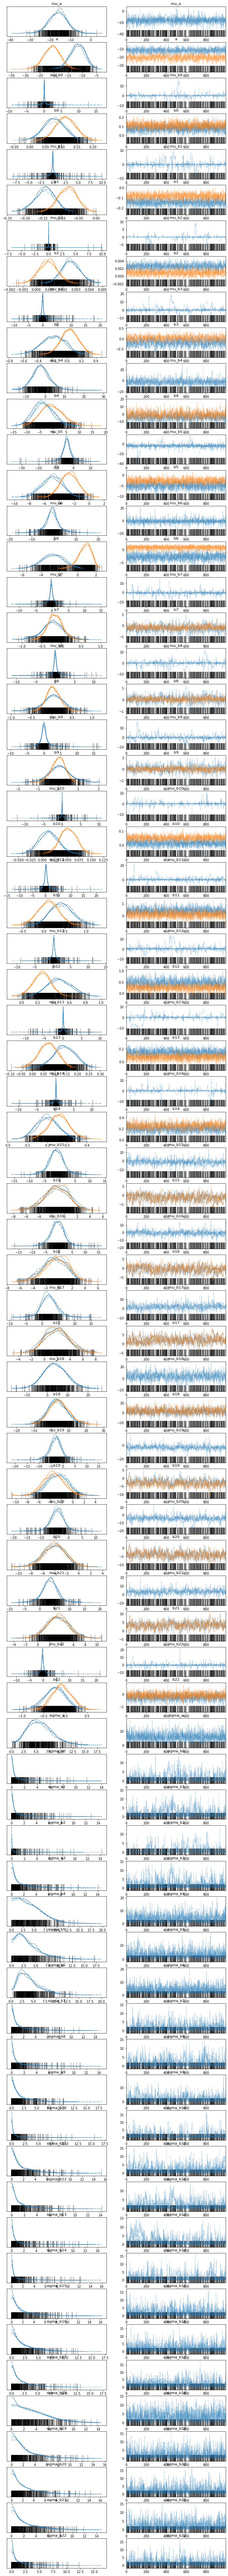

In [37]:
az.rcParams["plot.max_subplots"] = 200# This finishes without error
pm.plots.traceplot(hierarchical_trace_unnested)

In [44]:
sum_hierarchical_unnested = pm.summary(hierarchical_trace_unnested)
sum_hierarchical_unnested

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a      -16.244  4.872 -25.787   -7.297      0.134    0.095    1383.0   
a[Pre]    -11.711  2.712 -16.619   -6.518      0.099    0.071     776.0   
a[Post]   -20.703  2.936 -26.413  -15.252      0.113    0.080     651.0   
mu_b0       0.141  1.734  -2.665    3.497      0.140    0.116     444.0   
b0[Pre]     0.078  0.035   0.014    0.144      0.001    0.001    1508.0   
...           ...    ...     ...      ...        ...      ...       ...   
sigma_b18   3.477  2.702   0.023    8.453      0.081    0.057     790.0   
sigma_b19   2.351  2.297   0.007    6.740      0.068    0.048     901.0   
sigma_b20   2.239  2.281   0.009    6.472      0.082    0.058     739.0   
sigma_b21   2.280  2.269   0.010    6.594      0.073    0.052     769.0   
sigma_b22   1.662  2.029   0.003    5.559      0.085    0.060     427.0   

           ess_tail  r_hat  
mu_a         1502.0   1.00  
a[Pre]       1173.0   1.00  
a[Post]      1413.0   1.01  
mu_b0         235.0   1.01  
b0[Pre]      1909.0   1.00  
...             ...    ...  
sigma_b18     684.0   1.01  
sigma_b19     890.0   1.00  
sigma_b20    1188.0   1.00  
sigma_b21    1040.0   1.01  
sigma_b22     874.0   1.02  

[96 rows x 9 columns]

In [45]:
sum_hierarchical_unnested.sort_values('r_hat', ascending= False).head(20)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_b2   0.554  1.262   0.000    2.623      0.065    0.046     280.0   
mu_b2     -0.017  0.783  -0.980    1.169      0.044    0.033     636.0   
mu_b13    -0.040  1.955  -2.592    4.116      0.310    0.260     126.0   
sigma_b13  1.392  2.112   0.002    5.645      0.256    0.193     176.0   
sigma_b22  1.662  2.029   0.003    5.559      0.085    0.060     427.0   
sigma_b11  1.827  2.071   0.002    5.753      0.092    0.065     437.0   
mu_b17     2.039  2.668  -3.283    6.666      0.127    0.090     435.0   
b19[Post] -3.329  1.822  -6.704    0.020      0.097    0.068     359.0   
b19[Pre]  -2.590  1.866  -6.008    0.915      0.100    0.071     353.0   
mu_b19    -2.944  2.926  -8.681    2.208      0.139    0.098     447.0   
b17[Post]  1.963  1.865  -1.523    5.336      0.101    0.072     338.0   
b17[Pre]   1.963  1.874  -1.355    5.504      0.101    0.072     342.0   
b16[Pre]  -0.633  1.871  -4.082    2.835      0.101    0.071     346.0   
b16[Post] -0.276  1.867  -3.708    3.206      0.101    0.071     343.0   
b20[Pre]  -4.001  1.865  -7.552   -0.595      0.099    0.070     361.0   
mu_b16    -0.364  2.881  -5.718    4.617      0.128    0.090     448.0   
b15[Post] -1.166  1.864  -4.698    2.221      0.101    0.072     338.0   
b15[Pre]  -1.149  1.878  -4.668    2.222      0.101    0.072     344.0   
mu_b14     0.212  1.502  -2.466    3.119      0.094    0.066     433.0   
mu_b20    -4.066  2.901  -9.218    1.302      0.143    0.106     430.0   

           ess_tail  r_hat  
sigma_b2      537.0   1.05  
mu_b2         345.0   1.04  
mu_b13         31.0   1.03  
sigma_b13      77.0   1.03  
sigma_b22     874.0   1.02  
sigma_b11     706.0   1.02  
mu_b17        729.0   1.01  
b19[Post]     629.0   1.01  
b19[Pre]      639.0   1.01  
mu_b19        679.0   1.01  
b17[Post]     577.0   1.01  
b17[Pre]      611.0   1.01  
b16[Pre]      596.0   1.01  
b16[Post]     599.0   1.01  
b20[Pre]      695.0   1.01  
mu_b16       1127.0   1.01  
b15[Post]     611.0   1.01  
b15[Pre]      602.0   1.01  
mu_b14        155.0   1.01  
mu_b20        581.0   1.01

In [47]:
sum_hierarchical_unnested.sort_values('r_hat', ascending= False).tail(20)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b12[Post]   0.254  0.113   0.052    0.478      0.003    0.002    1059.0   
b13[Pre]    0.142  0.048   0.050    0.227      0.001    0.001    1037.0   
b13[Post]   0.069  0.041  -0.011    0.141      0.001    0.001    1428.0   
b14[Pre]    0.203  0.055   0.096    0.304      0.002    0.001     709.0   
b14[Post]   0.260  0.051   0.156    0.353      0.002    0.001     685.0   
a[Pre]    -11.711  2.712 -16.619   -6.518      0.099    0.071     776.0   
b9[Post]    0.008  0.338  -0.656    0.623      0.012    0.009     738.0   
b8[Post]    0.046  0.171  -0.268    0.376      0.006    0.004     742.0   
b7[Post]   -0.155  0.186  -0.521    0.191      0.007    0.005     746.0   
mu_b18      3.951  5.849  -6.789   15.235      0.221    0.156     701.0   
b18[Pre]    3.260  5.390  -6.767   13.341      0.209    0.148     666.0   
b18[Post]   4.552  5.584  -5.546   15.421      0.216    0.153     675.0   
mu_b7      -0.197  1.666  -3.477    2.843      0.070    0.053     819.0   
b6[Post]    0.805  0.686  -0.525    1.939      0.015    0.010    2351.0   
b6[Pre]    -2.732  1.162  -4.918   -0.578      0.031    0.022    1393.0   
mu_b6      -0.841  3.647  -7.519    6.915      0.117    0.103    1211.0   
b5[Post]   -2.637  1.159  -4.796   -0.510      0.034    0.024    1160.0   
b11[Post]   0.110  0.236  -0.355    0.527      0.007    0.005    1144.0   
b4[Post]   -0.421  4.187  -7.828    7.730      0.154    0.109     742.0   
mu_a      -16.244  4.872 -25.787   -7.297      0.134    0.095    1383.0   

           ess_tail  r_hat  
b12[Post]    1804.0    1.0  
b13[Pre]     2046.0    1.0  
b13[Post]    1881.0    1.0  
b14[Pre]     1660.0    1.0  
b14[Post]    1037.0    1.0  
a[Pre]       1173.0    1.0  
b9[Post]     1199.0    1.0  
b8[Post]     1226.0    1.0  
b7[Post]     1332.0    1.0  
mu_b18       1330.0    1.0  
b18[Pre]     1241.0    1.0  
b18[Post]    1181.0    1.0  
mu_b7         718.0    1.0  
b6[Post]     1935.0    1.0  
b6[Pre]      2118.0    1.0  
mu_b6         862.0    1.0  
b5[Post]     1811.0    1.0  
b11[Post]    1580.0    1.0  
b4[Post]     1603.0    1.0  
mu_a         1502.0    1.0

In [50]:
(sum_hierarchical_unnested['r_hat'] > 1.0).sum() / len(sum_hierarchical_unnested)

0.53125